In [2]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from models import AR_RNN, compile_and_fit_tf


2023-05-08 16:27:28.010022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### data setup

In [4]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [5]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)


In [6]:
def format_data_for_RNN(area_data, cols, lookback, lookforward):
    train_df, test_df = train_test_split(area_data[cols],
                                         test_size=0.3,
                                         shuffle=False)

    # normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_df[cols] = scaler.fit_transform(train_df[cols])
    test_df[cols] = scaler.transform(test_df[cols])

    X_train, y_train = utils.create_windowed_dataset(train_df, cols, lookback,
                                                     lookforward)
    X_test, y_test = utils.create_windowed_dataset(test_df, cols, lookback,
                                                   lookforward)
    return train_df, test_df, X_train, y_train, X_test, y_test, scaler
    # return {'train_df':train_df, 'test_df':test_df, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test, 'scaler':scaler}


In [7]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx])
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx])
    plt.title(title)

In [8]:
def plot_cumulative(area_data,
                    ground_truth_diff,
                    train_ts_diff,
                    test_ts_diff,
                    cols,
                    col_idx,
                    lookback,
                    lookforward,
                    fwd_offset=0,
                    title=''):
    init_train_offset = area_data.loc[lookback, 'average_price']
    init_test_offset = area_data.loc[
            lookback * 2 + fwd_offset + lookforward + len(train_ts_diff), 'average_price']
    plot_inputs_outputs(area_data, 
                        np.cumsum(ground_truth_diff) + init_train_offset,
                        np.cumsum(train_ts_diff).reshape(-1, 1) + init_train_offset,
                        np.cumsum(test_ts_diff).reshape(-1, 1) + init_test_offset, 
                        cols, col_idx,
                        lookback, lookforward, fwd_offset, title)

## single-step prediction

### predict raw price

#### data setup

In [9]:
cols = ["average_price"]
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [10]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


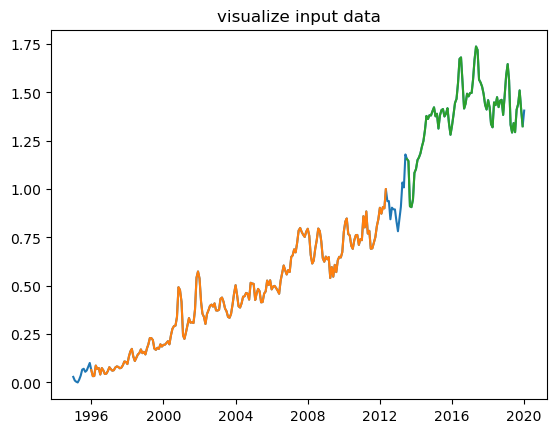

In [11]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [12]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


2023-05-08 16:27:39.441678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
7/7 [==============================] - 2s 50ms/step - loss: 0.0657 - mean_absolute_error: 0.2092 - val_loss: 0.2362 - val_mean_absolute_error: 0.4636
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0121 - mean_absolute_error: 0.0850 - val_loss: 0.4166 - val_mean_absolute_error: 0.6309
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_absolute_error: 0.0653 - val_loss: 0.1914 - val_mean_absolute_error: 0.4158
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_absolute_error: 0.0707 - val_loss: 0.2453 - val_mean_absolute_error: 0.4767
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_absolute_error: 0.0579 - val_loss: 0.1967 - val_mean_absolute_error: 0.4249
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0511 - val_loss: 0.1510 - val_mean_absolute_error: 0.3692
Epoch 7/50
7/7 [=======================

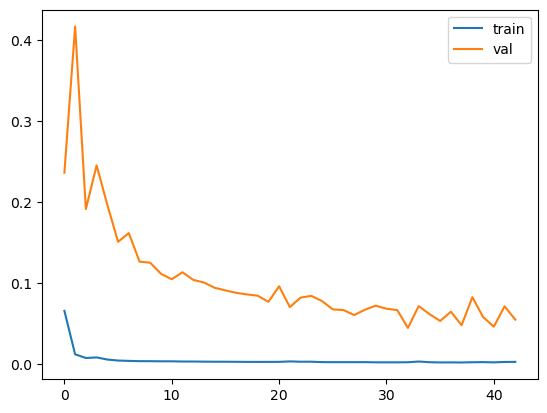

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

3/3 [==============================] - 0s 3ms/step


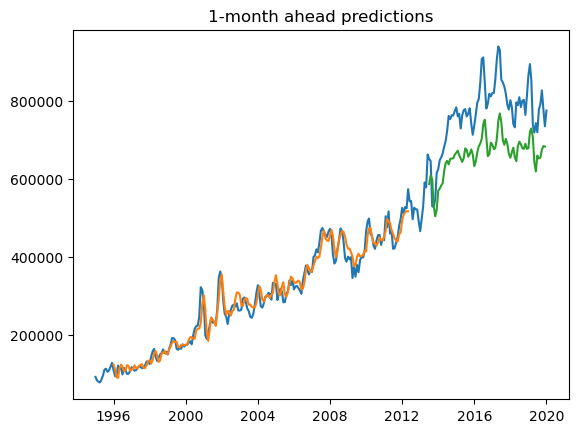

In [14]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


### multiple features

#### data

In [15]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [16]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 8)
(197, 1, 8)
(78, 12, 8)
(78, 1, 8)


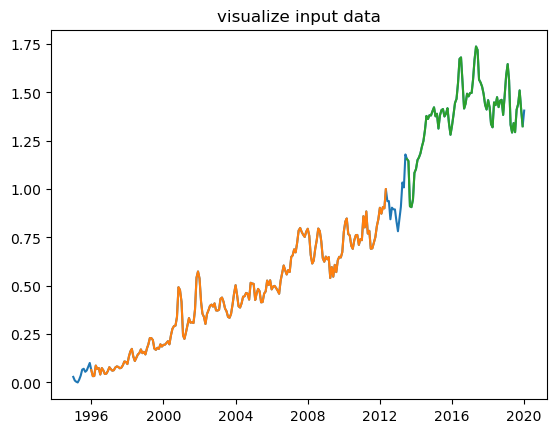

In [17]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [18]:
ar_rnn_model = AR_RNN(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
7/7 [==============================] - 1s 52ms/step - loss: 0.1305 - mean_absolute_error: 0.2641 - val_loss: 0.9166 - val_mean_absolute_error: 0.7313
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0288 - mean_absolute_error: 0.1327 - val_loss: 0.5261 - val_mean_absolute_error: 0.5392
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0201 - mean_absolute_error: 0.1103 - val_loss: 0.6817 - val_mean_absolute_error: 0.6222
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0127 - mean_absolute_error: 0.0878 - val_loss: 0.4625 - val_mean_absolute_error: 0.4801
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0114 - mean_absolute_error: 0.0813 - val_loss: 0.5318 - val_mean_absolute_error: 0.5193
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0087 - mean_absolute_error: 0.0713 - val_loss: 0.5113 - val_mean_absolute_error: 0.5044
Epoch 7/100
7/7 [===========

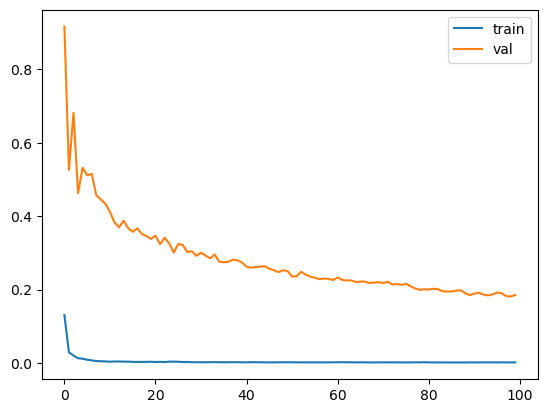

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [20]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 4ms/step


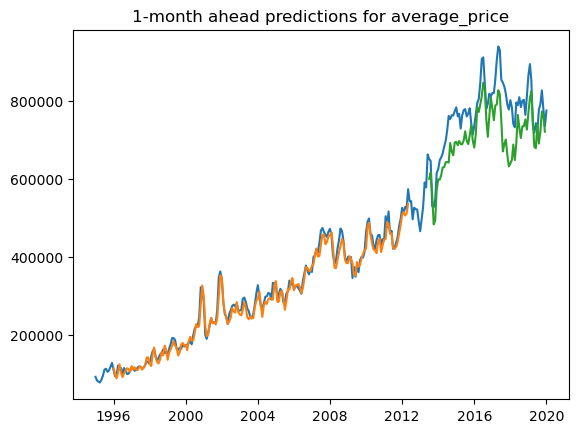

In [21]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


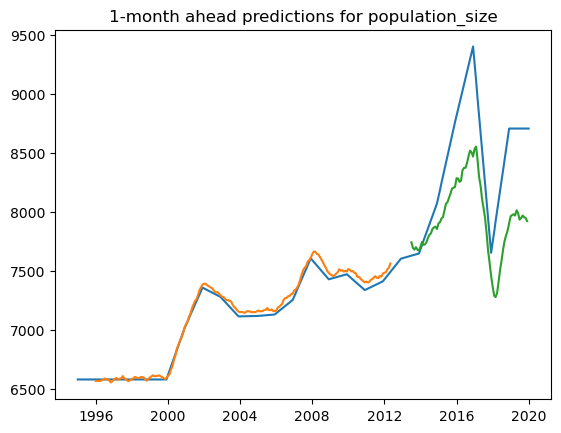

In [22]:
col_idx = 5
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


### predict diff

#### data

In [23]:
cols = ['average_price_d1']
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [24]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


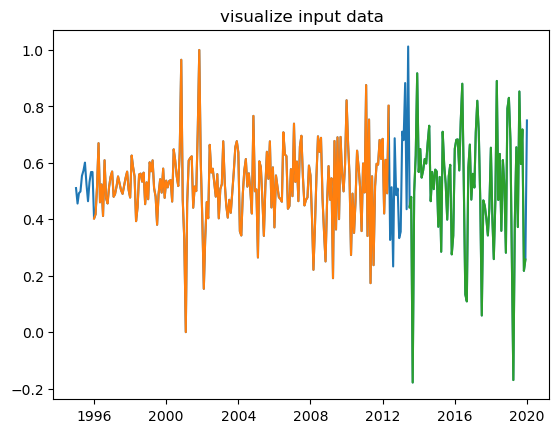

In [25]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [26]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 1s 44ms/step - loss: 0.0731 - mean_absolute_error: 0.2187 - val_loss: 0.0747 - val_mean_absolute_error: 0.2115
Epoch 2/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0371 - mean_absolute_error: 0.1522 - val_loss: 0.0568 - val_mean_absolute_error: 0.1830
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0231 - mean_absolute_error: 0.1169 - val_loss: 0.0513 - val_mean_absolute_error: 0.1693
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0187 - mean_absolute_error: 0.1020 - val_loss: 0.0480 - val_mean_absolute_error: 0.1740
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0188 - mean_absolute_error: 0.1034 - val_loss: 0.0462 - val_mean_absolute_error: 0.1619
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0172 - mean_absolute_error: 0.0964 - val_loss: 0.0440 - val_mean_absolute_error: 0.1648
Epoch 7/50
7/7 [=====================

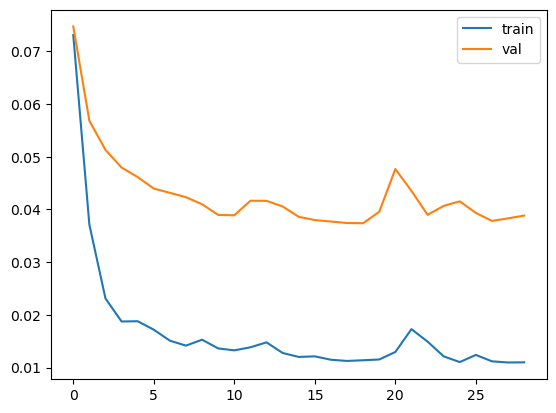

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [28]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 4ms/step


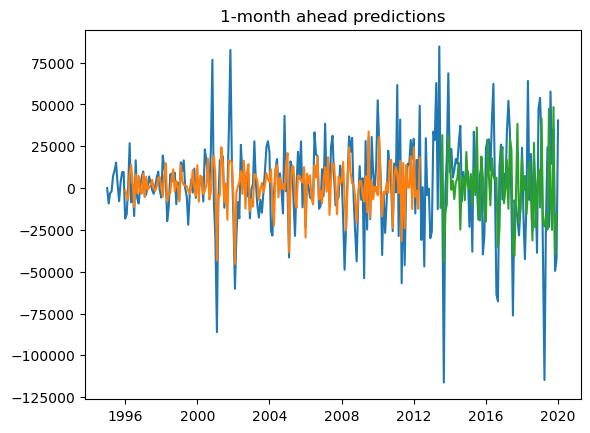

In [29]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=col_idx,
                    title='1-month ahead predictions')

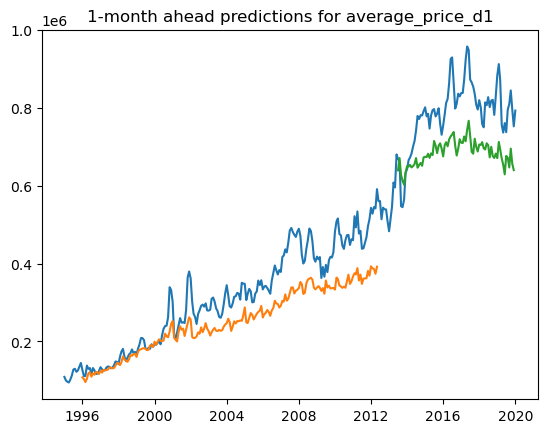

In [30]:
col_idx = 0
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


## autoregressive prediction

### predict raw

#### data setup

In [31]:
cols = ["average_price"]
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [32]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


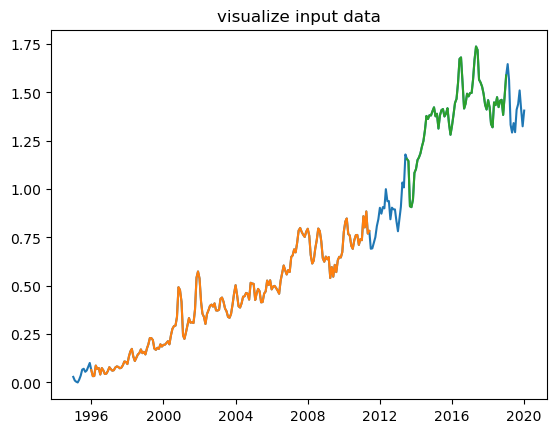

In [33]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [34]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 2s 91ms/step - loss: 0.0655 - mean_absolute_error: 0.1961 - val_loss: 0.7151 - val_mean_absolute_error: 0.8152
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0273 - mean_absolute_error: 0.1301 - val_loss: 0.9660 - val_mean_absolute_error: 0.9560
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0192 - mean_absolute_error: 0.1077 - val_loss: 0.5665 - val_mean_absolute_error: 0.7246
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0154 - mean_absolute_error: 0.1011 - val_loss: 0.6395 - val_mean_absolute_error: 0.7758
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0122 - mean_absolute_error: 0.0895 - val_loss: 0.5441 - val_mean_absolute_error: 0.7132
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0107 - mean_absolute_error: 0.0816 - val_loss: 0.6237 - val_mean_absolute_error: 0.7680
Epoch 7/50
6/6 [==================

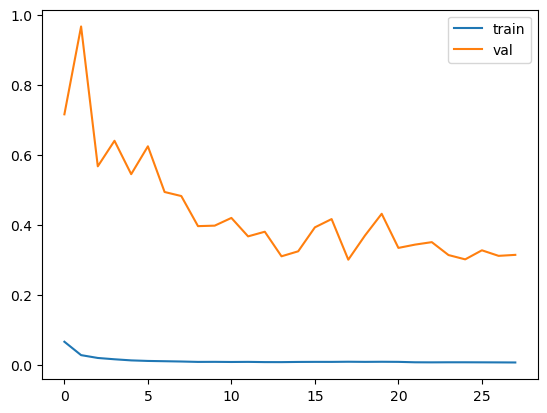

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [36]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 3ms/step


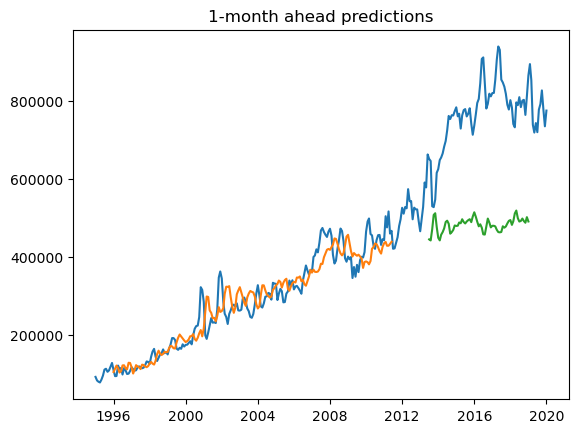

In [37]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')

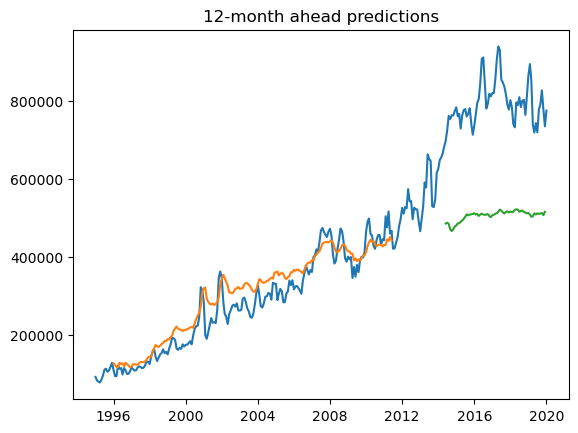

In [38]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-month ahead predictions')


### multiple features

#### data setup

In [39]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [40]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 8)
(186, 12, 8)
(67, 12, 8)
(67, 12, 8)


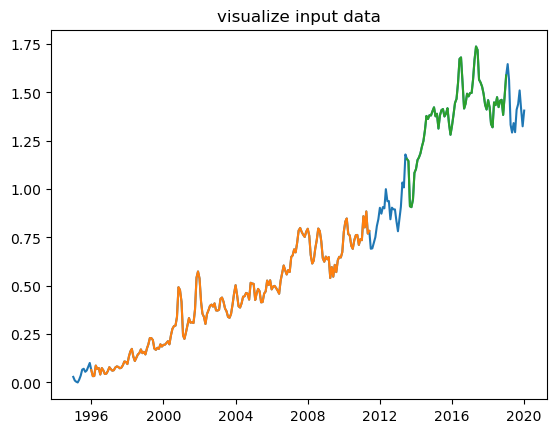

In [41]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [42]:
ar_rnn_model = AR_RNN(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
6/6 [==============================] - 2s 111ms/step - loss: 0.1935 - mean_absolute_error: 0.3458 - val_loss: 1.3316 - val_mean_absolute_error: 0.9044
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 0.0678 - mean_absolute_error: 0.2067 - val_loss: 1.5617 - val_mean_absolute_error: 0.9931
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0405 - mean_absolute_error: 0.1520 - val_loss: 1.3284 - val_mean_absolute_error: 0.8851
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0273 - mean_absolute_error: 0.1276 - val_loss: 1.0506 - val_mean_absolute_error: 0.7879
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0209 - mean_absolute_error: 0.1093 - val_loss: 0.9673 - val_mean_absolute_error: 0.7159
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0171 - mean_absolute_error: 0.0970 - val_loss: 0.9771 - val_mean_absolute_error: 0.7390
Epoch 7/100
6/6 [==========

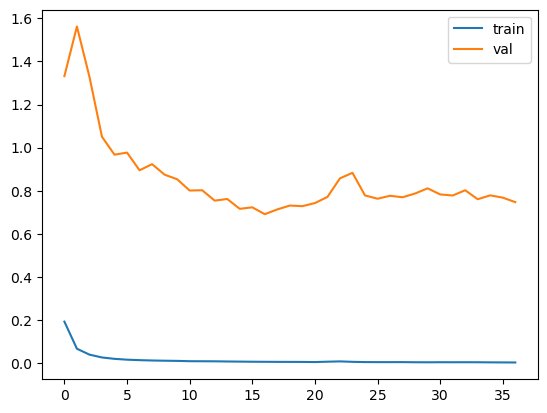

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [44]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 4ms/step


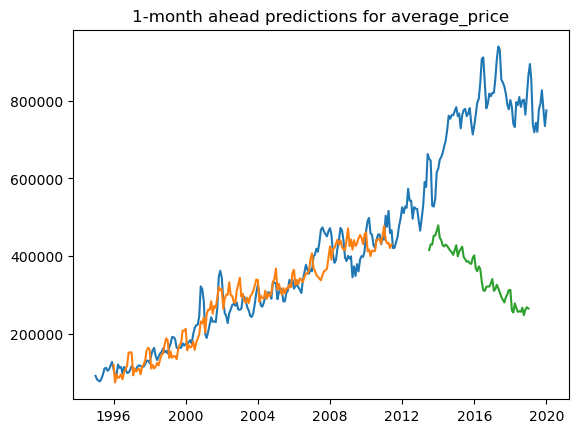

In [45]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


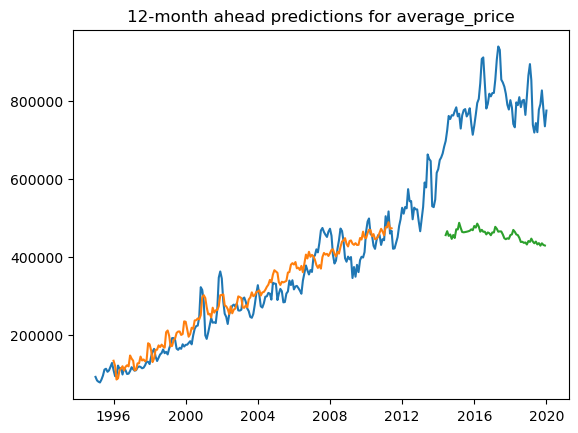

In [46]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


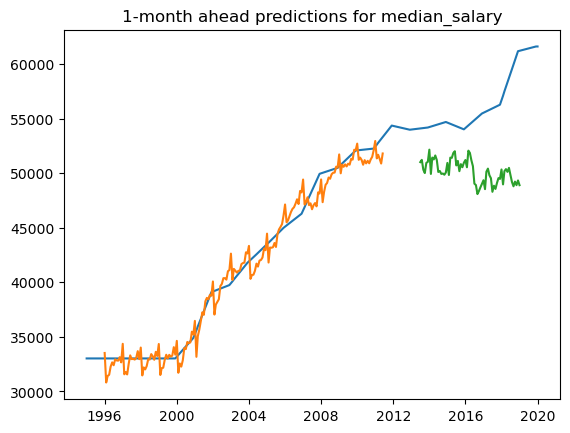

In [47]:
col_idx = 4
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


### predict diff

#### data

In [48]:
cols = ['average_price_d1']
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = format_data_for_RNN(
    area_data, cols, lookback, lookforward)

In [49]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


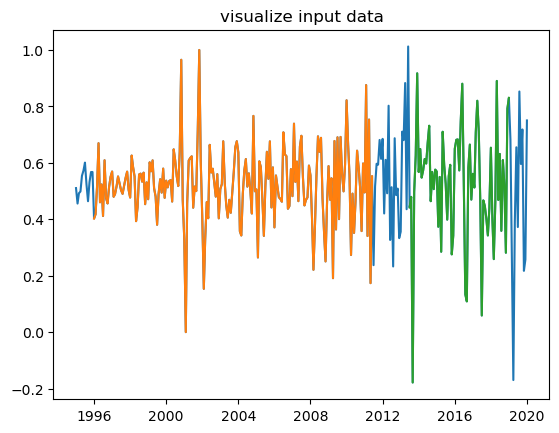

In [50]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [51]:
ar_rnn_model = AR_RNN(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_rnn_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 2s 88ms/step - loss: 0.1164 - mean_absolute_error: 0.2751 - val_loss: 0.0700 - val_mean_absolute_error: 0.2050
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0287 - mean_absolute_error: 0.1331 - val_loss: 0.0638 - val_mean_absolute_error: 0.2079
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0251 - mean_absolute_error: 0.1234 - val_loss: 0.0442 - val_mean_absolute_error: 0.1607
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0200 - mean_absolute_error: 0.1065 - val_loss: 0.0438 - val_mean_absolute_error: 0.1577
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0174 - mean_absolute_error: 0.0971 - val_loss: 0.0432 - val_mean_absolute_error: 0.1653
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0175 - mean_absolute_error: 0.0981 - val_loss: 0.0412 - val_mean_absolute_error: 0.1583
Epoch 7/50
6/6 [==================

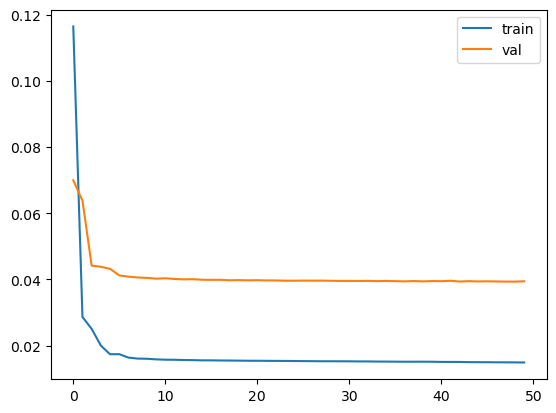

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [53]:
pred_train = ar_rnn_model.predict(X_train)  #[:, -1]
pred_test = ar_rnn_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 3ms/step


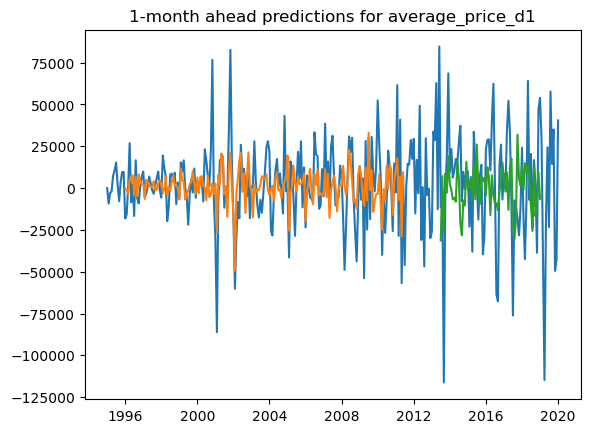

In [54]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


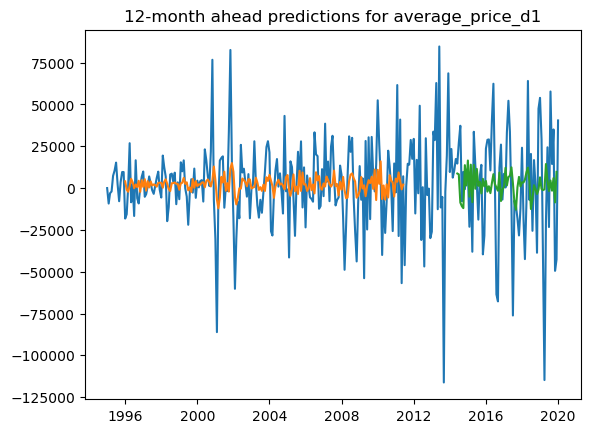

In [55]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


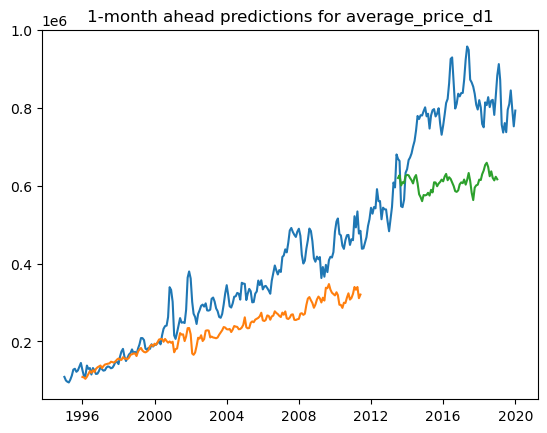

In [56]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


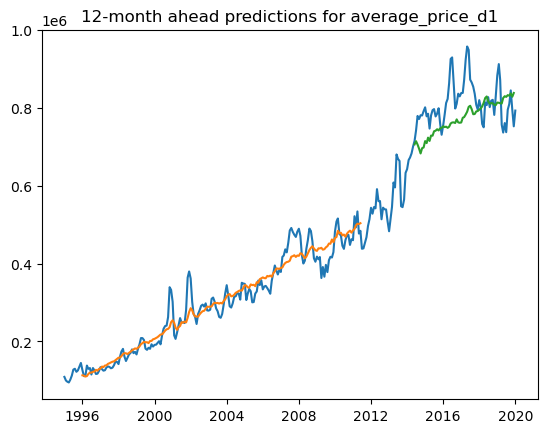

In [57]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_12mo_train_rescaled,
                test_ts_diff=pred_12mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=11,
                title=f'12-month ahead predictions for {cols[col_idx]}')
